# <center> Data Analytics and Machine Learning
***
### <center> Graph NDural Networks
### <center>Zijie Ren & Kieran Bell

# Outline

1. DeEinitions and basics oE GNN

2. Classic architectures oE GNN

    2.1 GCN

    2.2 GAT

2. Advanced applications

Graph Neural Networks (GNNs) are a class of deep learning methods designed to perform inference on data described by graphs. Unlike traditional neural networks that operate on grid-like structures (e.g., images) or sequences (e.g., text), GNNs can directly process graph-structured data, making them powerful tools for relational data representation.

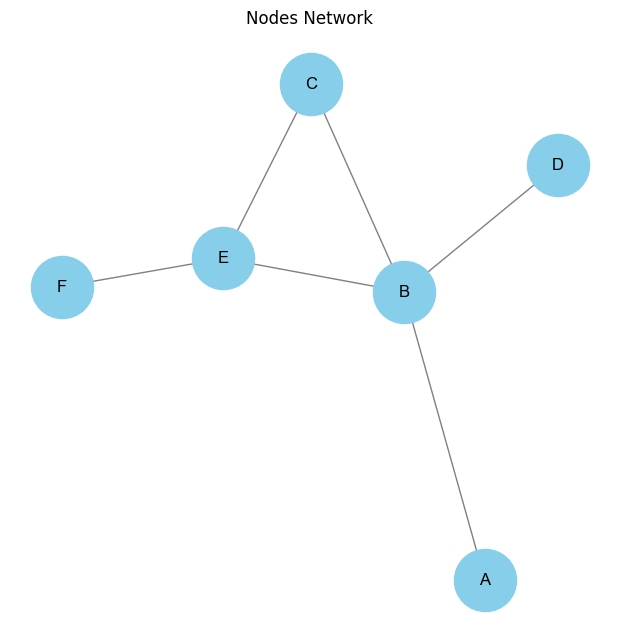

Adjacency matrix:
   A  B  C  D  E  F
A  0  1  0  0  0  0
B  1  0  1  1  1  0
C  0  1  0  0  1  0
D  0  1  0  0  0  0
E  0  1  1  0  0  1
F  0  0  0  0  1  0


In [55]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Define the edges list and nodes
edges = [
    ("A", "B"),
    ("B", "A"),
    ("B", "C"),
    ("B", "D"),
    ("B", "E"),
    ("C", "B"),
    ("C", "E"),
    ("D", "B"),
    ("E", "B"),
    ("E", "C"),
    ("E", "F"),
    ("F", "E")
]

# Plot the network
G = nx.Graph()
G.add_edges_from(edges)

plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color="skyblue", node_size=2000, edge_color="gray", font_size=12, font_family="Arial")
plt.title("Nodes Network")
plt.show()

# Generate adjacency matrix
nodes = sorted(set(sum(edges, ())))  # Get unique nodes and sort them
adj_matrix = pd.DataFrame(0, index=nodes, columns=nodes)  # Create an empty adjacency matrix

for a, b in edges:
    adj_matrix.at[a, b] = 1

print("Adjacency matrix:")
print(adj_matrix)


Basic components:

Node features: Vector representations of each node

Edge features: Optional information about relationships

Global features: Graph-level attributes (optional)

The fundamental operation in GNNs is neighborhood aggregation, where each node gathers information from its local neighborhood to compute updated representations.

----
2. Classic Architectures of GNN

    2.1 Graph Neural Network (GNN)

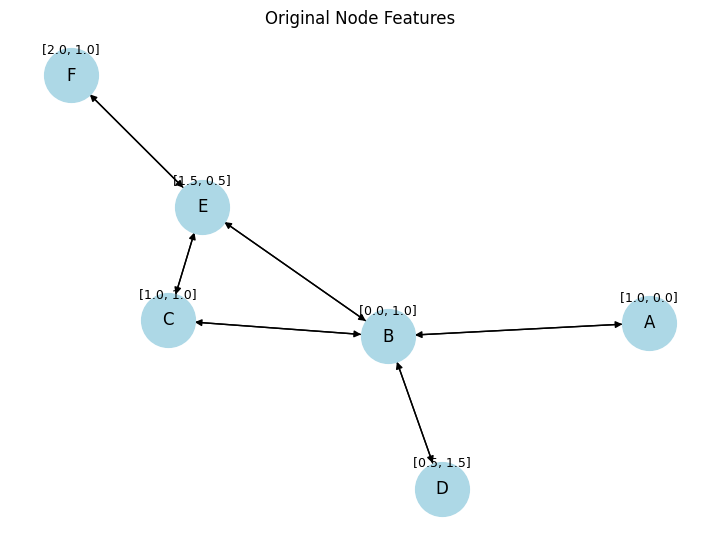

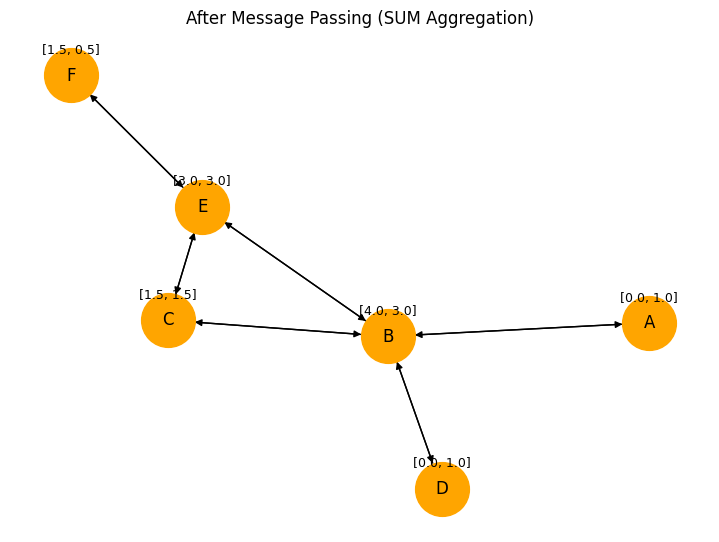

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Define a custom graph
edges = [
    ("A", "B"), ("B", "A"),
    ("B", "C"), ("B", "D"), ("B", "E"),
    ("C", "B"), ("C", "E"),
    ("D", "B"),
    ("E", "B"), ("E", "C"),
    ("E", "F"),
    ("F", "E")
]
nodes = ["A", "B", "C", "D", "E", "F"]

# Map node names to indices
node_to_idx = {node: i for i, node in enumerate(nodes)}

# Build adjacency list
adj_list = {node: [] for node in nodes}
for src, tgt in edges:
    adj_list[src].append(tgt)

# Define initial node features (2D vectors for each node)
features = torch.tensor([
    [1.0, 0.0],  # A
    [0.0, 1.0],  # B
    [1.0, 1.0],  # C
    [0.5, 1.5],  # D
    [1.5, 0.5],  # E
    [2.0, 1.0]   # F
])

# Visualize the original graph with node features
G = nx.DiGraph()
G.add_edges_from(edges)
pos = nx.spring_layout(G, seed=42)  # consistent layout

plt.figure(figsize=(7, 5))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1500)
for node in nodes:
    idx = node_to_idx[node]
    feat = features[idx].tolist()
    plt.text(pos[node][0], pos[node][1] + 0.1, f"{feat}", fontsize=9, ha='center')
plt.title("Original Node Features")
plt.show()

# Perform one round of SUM-based message passing
new_features = []
for node in nodes:
    idx = node_to_idx[node]
    neighbors = adj_list[node]
    agg = torch.zeros_like(features[idx])  # start with zero vector
    for nbr in neighbors:
        nbr_idx = node_to_idx[nbr]
        agg += features[nbr_idx]  # SUM over neighbors' features
    new_features.append(agg)

new_features = torch.stack(new_features)

# Visualize updated node features
plt.figure(figsize=(7, 5))
nx.draw(G, pos, with_labels=True, node_color='orange', node_size=1500)
for node in nodes:
    idx = node_to_idx[node]
    feat = new_features[idx].tolist()
    plt.text(pos[node][0], pos[node][1] + 0.1, f"{feat}", fontsize=9, ha='center')
plt.title("After Message Passing (SUM Aggregation)")
plt.show()


Applications:

Node Classification (e.g., detect fraud users in a social network)

Link Prediction (e.g., recommend friends or products)

Graph Classification (e.g., molecule property prediction)

Knowledge Graph Completion (fill in missing relations)

----

Graph Convolutional Networks (GCNs) are a powerful type of neural network designed for learning on graph-structured data. Unlike traditional neural networks that assume grid-like input (e.g., images or sequences), GCNs perform feature transformation and information aggregation directly on nodes and their neighbors. The core operation of a GCN layer involves multiplying the node feature matrix with a normalized adjacency matrix, followed by a learnable weight matrix and non-linear activation. This enables each node to update its representation by combining its own features with those of its connected neighbors, weighted by their graph connectivity. GCNs are especially effective for tasks such as node classification, link prediction, and graph-level classification, where the structure of relationships is as important as the individual node attributes. The model’s ability to incorporate both feature and topological information makes it a fundamental tool in modern graph-based machine learning.

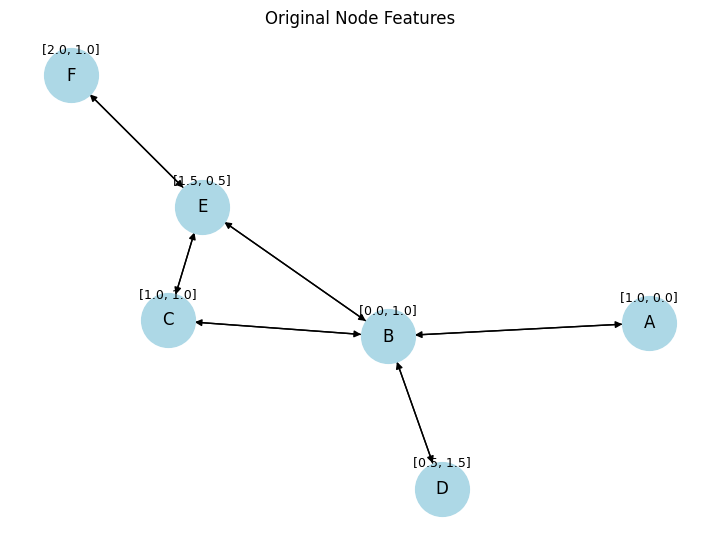

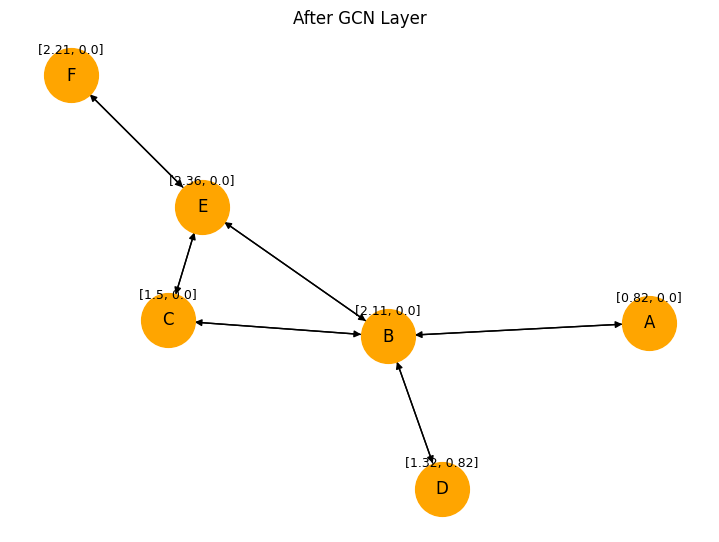

In [58]:
import torch
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt

# Define a graph
edges = [
    ("A", "B"), ("B", "A"),
    ("B", "C"), ("B", "D"), ("B", "E"),
    ("C", "B"), ("C", "E"),
    ("D", "B"),
    ("E", "B"), ("E", "C"),
    ("E", "F"),
    ("F", "E")
]
nodes = ["A", "B", "C", "D", "E", "F"]
node_to_idx = {node: i for i, node in enumerate(nodes)}

# Initial node features (each node has a 2D feature vector)
features = torch.tensor([
    [1.0, 0.0],  # A
    [0.0, 1.0],  # B
    [1.0, 1.0],  # C
    [0.5, 1.5],  # D
    [1.5, 0.5],  # E
    [2.0, 1.0]   # F
])

# Create adjacency matrix (symmetric with self-loops)
N = len(nodes)
adj = torch.zeros(N, N)
for u, v in edges:
    i, j = node_to_idx[u], node_to_idx[v]
    adj[i, j] = 1

# Add self-loops
adj += torch.eye(N)

# Compute degree matrix
deg = adj.sum(dim=1)  # degree of each node
deg_inv_sqrt = torch.pow(deg, -0.5)
deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0.0

# GCN normalization: D^(-1/2) * A * D^(-1/2)
D_inv_sqrt = torch.diag(deg_inv_sqrt)
adj_norm = D_inv_sqrt @ adj @ D_inv_sqrt

# Define a weight matrix W (2 input features -> 2 output features)
W = torch.tensor([[1.0, -1.0],
                  [1.0, 1.0]])

# Apply GCN layer: A_hat @ X @ W
h = adj_norm @ features @ W
h = F.relu(h)  # apply non-linearity

# Visualization (Before and After GCN)
G = nx.DiGraph()
G.add_edges_from(edges)
pos = nx.spring_layout(G, seed=42)

# Before
plt.figure(figsize=(7, 5))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1500)
for node in nodes:
    idx = node_to_idx[node]
    feat = features[idx].tolist()
    plt.text(pos[node][0], pos[node][1]+0.1, f"{feat}", fontsize=9, ha='center')
plt.title("Original Node Features")
plt.show()

# After
plt.figure(figsize=(7, 5))
nx.draw(G, pos, with_labels=True, node_color='orange', node_size=1500)
for node in nodes:
    idx = node_to_idx[node]
    feat = h[idx].detach().tolist()
    plt.text(pos[node][0], pos[node][1]+0.1, f"{[round(x, 2) for x in feat]}", fontsize=9, ha='center')
plt.title("After GCN Layer")
plt.show()


---

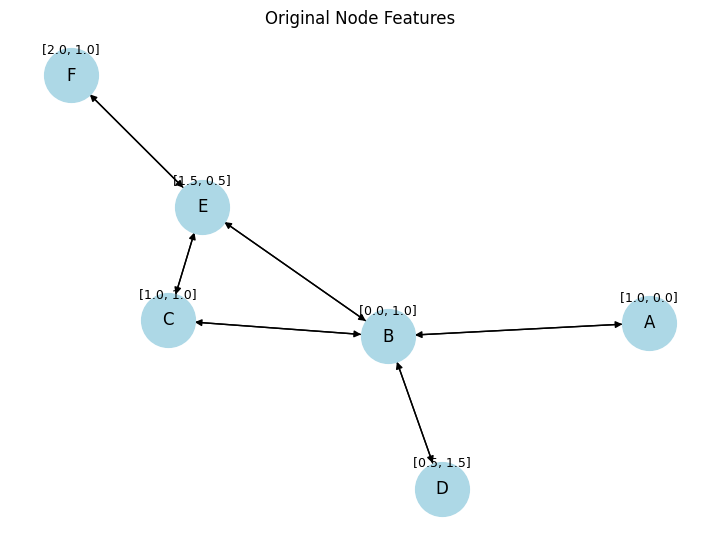

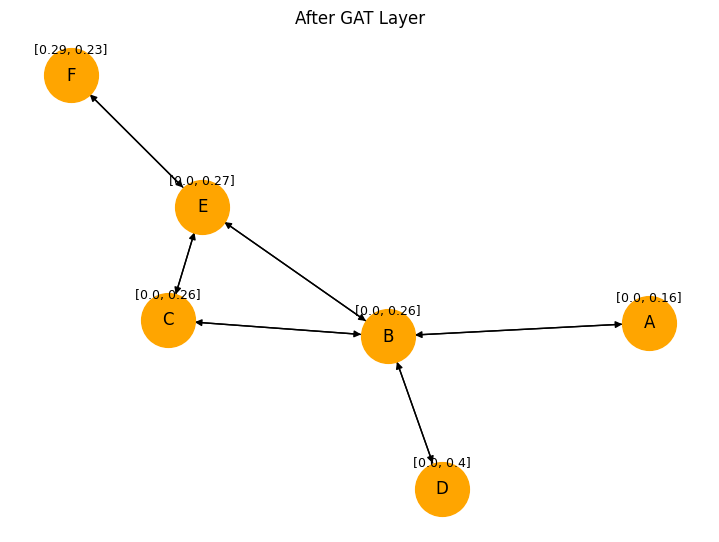

In [59]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt

# Define the graph
edges = [
    ("A", "B"), ("B", "A"),
    ("B", "C"), ("B", "D"), ("B", "E"),
    ("C", "B"), ("C", "E"),
    ("D", "B"),
    ("E", "B"), ("E", "C"),
    ("E", "F"),
    ("F", "E")
]
nodes = ["A", "B", "C", "D", "E", "F"]
node_to_idx = {node: i for i, node in enumerate(nodes)}

# Initial node features
features = torch.tensor([
    [1.0, 0.0],  # A
    [0.0, 1.0],  # B
    [1.0, 1.0],  # C
    [0.5, 1.5],  # D
    [1.5, 0.5],  # E
    [2.0, 1.0]   # F
])

# Build adjacency list
adj_list = [[] for _ in range(len(nodes))]
for u, v in edges:
    adj_list[node_to_idx[u]].append(node_to_idx[v])

# Simple GAT Layer (Single-head)
class SimpleGATLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.W = nn.Linear(in_dim, out_dim, bias=False)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)

    def forward(self, features, adj_list):
        h = self.W(features)
        N = h.size(0)
        new_h = []

        for i in range(N):
            neighbors = adj_list[i] + [i]  # self-loop
            attn_scores = []

            for j in neighbors:
                a_input = torch.cat([h[i], h[j]])
                e_ij = self.attn_fc(a_input)
                attn_scores.append(e_ij)

            e = torch.stack(attn_scores).squeeze()
            alpha = F.softmax(e, dim=0)

            agg = sum(alpha[k] * h[neighbors[k]] for k in range(len(neighbors)))
            new_h.append(agg)

        return F.relu(torch.stack(new_h))

# Instantiate and run GAT
gat = SimpleGATLayer(2, 2)
h_gat = gat(features, adj_list).detach()

# Visualization
G = nx.DiGraph()
G.add_edges_from(edges)
pos = nx.spring_layout(G, seed=42)

# Before GAT
plt.figure(figsize=(7, 5))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1500)
for node in nodes:
    idx = node_to_idx[node]
    feat = features[idx].tolist()
    plt.text(pos[node][0], pos[node][1]+0.1, f"{feat}", fontsize=9, ha='center')
plt.title("Original Node Features")
plt.show()

# After GAT
plt.figure(figsize=(7, 5))
nx.draw(G, pos, with_labels=True, node_color='orange', node_size=1500)
for node in nodes:
    idx = node_to_idx[node]
    feat = h_gat[idx].tolist()
    plt.text(pos[node][0], pos[node][1]+0.1, f"{[round(x, 2) for x in feat]}", fontsize=9, ha='center')
plt.title("After GAT Layer")
plt.show()
